# Detecting NYC Traffic Anomalies Final Models Notebook

In this notebook I will walkthrough the code to automate fitting the final model I created in the last notebook to all of the senors. If you are wondering how I got to the model we will be using, I recommend looking at the <b>Modeling Notebook</b> before continuing on with this one. Additionally, I will also walkthrough the code to detect traffic anomalies.

## Libraries Needed

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
plt.style.use('fivethirtyeight')
import folium
from keras.losses import mean_squared_error
import keras
import tensorflow as tf
import pickle
import sqlite3
%matplotlib inline

## Custom Functions Needed

In [2]:
def day_of_week_agg(df):
    """
    Takes in a dataframe with an index of datetimes and groups the rows by the day of the week and then
    averages the each column for all of the rows by the hour and minute in that groups.
    The output of this function is a list of dataframes. One dataframe for each day of the week.
    """
    #create an array of integers with the value equal to the day of the week for that row (0=Monday, 6=Sunday)
    int_array = df.apply(lambda x: x.name.weekday(), axis = 1)
    #instantiate an empty list
    day_dfs = []
    
    #for each day of the week do the following
    for i in range(7):
        # make a new dataframe of only the rows with the day of the week i
        day = df[(int_array == i)]
        # average the data based on the minute of the day
        day_agg = day.groupby([day.index.hour, day.index.minute]).mean()
        # append the aggregated dataframe to a list
        day_dfs.append(day_agg)
    #return the list of aggregated dataframes
    return day_dfs

In [3]:
def standardize_df(dataframe, column, X_steps, y_steps, num_train_sets):
    """
    This function standardizes the data of a column.
    
    dataframe: dataframe to standarize
    column: the column in the dataframe to standardize
    X_steps: the number of rows used to train on
    y_steps: the number of rows used to test on
    num_train_sets: the number of training sets there are for this dataframe
    """
    #import needed libraries
    from sklearn.preprocessing import StandardScaler
    
    #slice the dataframe down to the column to be scaled
    df = pd.DataFrame(dataframe[column])
    
    # initialize the standard scaler
    scaler = StandardScaler()
    #train the standard scaler on the rows that will be in the training set
    scaler = scaler.fit(df.iloc[:(num_train_sets * (X_steps + y_steps))])
    #save the mean used to standardize the dataframe
    mean = df.iloc[:(num_train_sets * (X_steps + y_steps))].mean().iloc[0]
    #save the standard deviation used to standardize the dataframe
    std = df.iloc[:(num_train_sets * (X_steps + y_steps))].std().iloc[0]
    
    # standardize the dataframe
    df = pd.DataFrame(scaler.transform(df), columns=[column])
    
    # return the standardized dataframe with the mean and standard deviation used to standardize
    return df, mean, std

In [4]:
def train_val_test_dfs(dataframe, column, X_steps=50, y_steps=1, val_size=0.2, test_size=0.1, standardize=False):
    """
    This function splits a dataframe into training, testing and
    validation sets.
    
    dataframe: dataframe to split
    column: string of the column in the dataframe to use since our application is a univariate timeseries
    X_steps: integer of the number of rows used to train on
    y_steps: integer of the number of rows used to predict on
    val_size: float less than 1.0 of the percentage of the dataframe to be for validation
    test_size: float less than 1.0 of the percentage of the dataframe to be for testing
    standardize: boolean indicating whether or not to standardize the sets
    """
    
    # calculate the number of sets that are possible given the amount of steps to train and predict on
    num_sets = len(dataframe) // (X_steps + y_steps)
#     num_sets = len(dataframe) - (X_steps + y_steps) + 1
    # calculate how to offset the data so that the sets are of the most recent data
    offset = (len(dataframe) % (X_steps + y_steps))
#     offset = 0
    # calculate the number of validation sets
    num_val_sets = int(num_sets * val_size)
    # calculate the number of test sets
    num_test_sets = int(num_sets * test_size)
    # calculate the number of training sets
    num_train_sets = num_sets - num_val_sets - num_test_sets
    
    # if the dataframe needs to be standardized then standardize it. Otherwise pass on the dataframe given
    if standardize:
        df, mean, std = standardize_df(dataframe, column, X_steps, y_steps, num_train_sets)
    else:
        df = dataframe.copy()
        
    # instantiate empty lists for each type of set
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []
    # loop the number of sets the dataframe can produce
    for i in range(num_sets):
        # if i is less than the number of training sets to be produced make another training set
        if i < num_train_sets:
            X_train.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_train.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
        # else if i is less than the number of validation sets to be produced make another validation set
        elif i < (num_train_sets + num_val_sets):
            X_val.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_val.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
        # else make a testing set
        else:
            X_test.append(np.array(df[column].iloc[(i*X_steps) + offset: (i*X_steps) + X_steps + offset])[:, np.newaxis])
            y_test.append(np.array(df[column].iloc[(i*X_steps) + X_steps + offset: (i*X_steps) + X_steps + offset + y_steps])[:, np.newaxis])
    # turn the lists into arrays so keras can process the each set
    if standardize:
        return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), mean, std
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

## Establish Connection to Database

We want to connect to a database because there is important informationt that we will generate that we want to be able to keep track of. For example, we want to be able to store the metrics for the final model of each sensor so we can do further analysis on the overall state of our system. I'm using sqlite3 for my database, but you can use any one you want. However, the code will probably be slightly different.

In [5]:
# Establish a connection to the database you want to use. If you are creating a new database
# the code is the same. Just name the database in a way that makes sense to you and it will
# be created in the same folder as this notebook.
conn = sqlite3.connect('traffic_flow.db')

# Instantiate a cursor instance to interact with your database
c = conn.cursor()

In [ ]:
# Create table - MODEL_METRICS
c.execute('''CREATE TABLE MODEL_METRICS
             ([sensor_id] INTEGER,
             [date] TEXT,
             [data_from] TEXT,
             [data_to] TEXT,
             [training_mean] FLOAT,
             [training_std] FLOAT,
             [baseline_loss] FLOAT,
             [model_train_loss] FLOAT,
             [model_test_loss] FLOAT,
             PRIMARY KEY (sensor_id, date))''')
          

In [6]:
# commit the changes
conn.commit()

## Import Data

In [7]:
with open('sensor_dfs.pickle', 'rb') as handle:
    sensor_dfs = pickle.load(handle)

In [8]:
# initialize the steps we will use for each sensor (explained in Modeling Notebook)
X_steps = 6
y_steps = 3

## Training a Model for Each Sensor

### Create function so that we can easily loop through the training for each sensor

In [9]:
def sensor_etl(df, ID, filename, X_steps, y_steps):
    """
    This function takes in a dataframe of sensor data and trains a model
    for the sensor. It additionally saves two graphs for the sensor.
    One shows the average weekly speed of the sensor and the other shows the avergage daily
    trend of the sensor for each day of the week. Finally, it saves the model and uploads
    key model paramters to an sql database
    
    data: input dictionary with each key being a sensor and its value the dataframe
    ID: sensor ID
    filename: the prefix of the name of the files you want the graphs and model to be saved under
    X_steps: number of steps to take in for prediction
    y_steps: number of steps to predict
    """
        
    #import libraries
    from IPython.display import clear_output
    import datetime
    #get date information
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.000")
    data_from = df.index.min().strftime("%Y-%m-%d %H:%M:%S.000")
    data_to = df.index.max().strftime("%Y-%m-%d %H:%M:%S.000")
    
    # Group the time series into weekly buckets
    sens_weekly = df['SPEED'].resample('7D')

    # Take the mean of each group 
    sens_weekly_mean = sens_weekly.mean()
    
    #plot the generic trend and save the figure
    fig1, ax1 = plt.subplots(figsize=(16,8))
    sens_weekly_mean.plot(color='blue', ax=ax1);
    fig1.set_facecolor('white')
    fig1.suptitle('Weekly Traffic Speeds (' + filename + ')')
    ax1.grid(axis='y')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average Traffic Speed (MPH)')
    ax1.set_facecolor('white')
    for x in ['bottom', 'top', 'right', 'left']:
        ax1.spines[x].set_color('black')
    
    plt.savefig(filename + '_weekly_trend', bbox_inches='tight', facecolor='white')
    plt.close()

    #aggregate all of the data to each weekday and plot that data
    weekly_agg = day_of_week_agg(df)

    fig2, ax2 = plt.subplots(figsize=(16,8));
    for i in range(7):
        colors= ['blue', 'red', 'orange', 'green', 'gray', 'purple', 'darkblue']
        weekly_agg[i]['SPEED'].plot(ax=ax2, color=colors[i], alpha=0.75);
    color='black'   
    fig2.legend(labels=['Monday', 'Tuesday', 'Wednesday', 'Thurday', 'Friday', 'Saturday', 'Sunday']
               , edgecolor='black', framealpha=1, loc=(.85,.101), facecolor='white')
    fig2.set_facecolor('white')
    fig2.suptitle('Average Traffic Speeds Per Day (' + filename + ')', color=color)
    ax2.grid(axis='y')
    ax2.set_xticks([287, 251, 215, 179, 143, 107, 71, 35, 0])
    ax2.set_xticklabels(['12am', '9pm', '6pm', '3pm', '12pm', '9am', '6am', '3am', '12am'], color=color)
    ax2.set_xlabel('Time', color=color)
    ax2.set_ylabel('Average Traffic Speed (MPH)', color=color)
    ax2.set_facecolor('white')
    ax2.tick_params(axis='y', colors=color)
    for x in ['bottom', 'top', 'right', 'left']:
        ax2.spines[x].set_color('black')
    plt.savefig(filename + '_weekdays', bbox_inches='tight', facecolor='white')
    plt.close()
    

    #standardize data and split into train, val and test sets
    X_train, y_train, X_val, y_val, X_test, y_test, mean, std = train_val_test_dfs(dataframe = df, column = 'SPEED', X_steps = X_steps, y_steps = y_steps, standardize=True)
    
    #------MODELING------
    #Baseline
    y_pred = X_val[:, -y_steps:]

    baseline_loss = np.mean(mean_squared_error(y_val, y_pred))

    #Final Model
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[X_steps, 1]),
        keras.layers.Dense(200),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(20),
        keras.layers.Dense(y_steps)
    ])

    model.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())
    #save history of fiting model
    history = model.fit(X_train, y_train, epochs = 5, verbose=0)
    #retrieve and save training loss
    train_loss = history.history['loss'][-1]
    #save validation loss
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    
    #save to SQL database
    c.execute(f'''
                    INSERT INTO MODEL_METRICS (sensor_id,
                                               date,
                                               data_from,
                                               data_to,
                                               training_mean,
                                               training_std,
                                               baseline_loss,
                                               model_train_loss,
                                               model_test_loss)
                                VALUES (
                                        {ID},
                                        '{date}',
                                        '{data_from}',
                                        '{data_to}',
                                        {mean},
                                        {std},
                                        {baseline_loss},
                                        {train_loss},
                                        {val_loss})

             ''')
    #commit the changes
    conn.commit()
    #save the model
    model.save(filename + '_model')
      
    clear_output(wait=True)

### Implement Function

In [ ]:
# This loops through each sensor dataframe and applies the function we just made to it.

# instantiate an empty dictionary to keep track of any errors
errors = {}
for key, value in tqdm.tqdm(sensor_dfs.items()):
    # try the following
    try:
        # name each file after the sensor
        filename = f'Sensor_{key}'
        # apply previously made function
        sensor_etl(df = value, ID = key, filename = filename, X_steps = X_steps, y_steps = y_steps)
    # if their is an error save the sensor number that had an error and the error message
    except Exception as e:
        errors[key] = e

In [ ]:
errors

Great, we had zero errors!

## Explore Final Model Data

In [10]:
# query for our average model metrics
c.execute(''' SELECT AVG(model_train_loss), AVG(model_test_loss), AVG(training_mean), AVG(training_std) FROM MODEL_METRICS''');
avg_performance = c.fetchone()

In [11]:
print(f'Average training loss: {avg_performance[0] ** 0.5:.4f}')
print(f'Average testing loss: {avg_performance[1] ** 0.5:.4f}')
print(f'Average training mean: {avg_performance[2]:.4f}')
print(f'Average training standard deviation: {avg_performance[3]:.4f}')

Average training loss: 0.3471
Average testing loss: 0.3706
Average training mean: 35.7682
Average training standard deviation: 13.4657


These metrics look good. Our averages were inline with what we achieved in the modeling notebook. Let's visualize these metrics in a more impactful way!

In [12]:
# query for all of model metrics
c.execute(''' SELECT model_train_loss, model_test_loss FROM MODEL_METRICS''');
data = c.fetchall()
all_models_train_loss = [x[0] ** 0.5 for x in data]
all_models_test_loss = [x[1] ** 0.5 for x in data]
loss_df = pd.DataFrame([all_models_train_loss, all_models_test_loss], index=[0.5, 1.5]).T

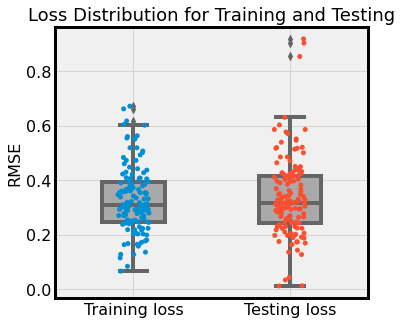

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
             
sns.stripplot(data=loss_df, jitter=1, ax=ax)
sns.boxplot(data=loss_df, width=0.4, color='darkgrey', ax=ax)
ax.grid(color='lightgrey')
ax.set_xticklabels(['Training loss', 'Testing loss'], fontsize=16)
ax.set_yticklabels([0.0,0.0,0.2,0.4,0.6,0.8], fontsize=16)
ax.set_ylabel('RMSE', fontsize=16)
ax.set_title('Loss Distribution for Training and Testing', fontsize=18)
for x in ['bottom', 'top', 'right', 'left']:
    ax.spines[x].set_color('black')
    
plt.savefig('loss_distribution', bbox_inches='tight', facecolor='white')

Very nice! This gives us more robust information. We can now visualize the quartiles of our metrics and see the training vs testing distributions side by side. They look very similar, which is good because that highlights that our model is well-balanced.

## Anomaly Detection

For this section, I'm only going to walkthrough an example for one sensor (sensor 142). In future notebooks I hope to automate this process for all the sensors.

In [14]:
# load model for selected sensor
model = keras.models.load_model('Sensor_142_model/')

For this example we are only going to focus on the last 30 days of data for this sensor. We need to format the last thirty days of data into tuples that we can input into our model.

In [15]:
# query for our model mean and standard deviation
c.execute(''' SELECT training_mean, training_std FROM MODEL_METRICS WHERE sensor_id = 142''');
metrics_142 = c.fetchone()
mean, std = metrics_142[0], metrics_142[1]

In [16]:
# 30 days of data 288 * 30
num = 8640
# standardize data
data = (sensor_dfs[142]['SPEED'].iloc[-num:] - mean) / std
# instantiate empty list
temp = []
# for as many sets as you can get from the sensor data do the following
for i in range(num - 5):
    # add to temp list the next six data points in the correct tuple format
    temp.append(data.iloc[i:i + 6][:, np.newaxis])
# save formatted data
x_data = np.array(temp)
# save x values (datetimes)
xs = data.index[-(num - 5):]
# save actual speed values
actual = data.values[-(num - 5):] * std + mean
# calculate and save predicted speed values
predictions = model.predict(x_data)[:,0].flatten() * std + mean

Now that we have all of our data ready we can visualize our anomaly detection in a simulated real-time graph.

In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
# the only way this worked for me was using the tk magic command instead of inline
# this will open the plot in a new window
%matplotlib tk

# Create figure for plotting
fig, ax = plt.subplots(figsize=(10,5))

#initialize values
x = []
y = []
cmap = []
expected = []
index = 0

# This function is called periodically from FuncAnimation
def animate(i, x, y, cmap, index, expected):
    
    # get speed value for this step
    speed = actual[i]
    # get date value for this step
    date = xs[i]
    
    # if this is the first step do the following
    if i == 0:
        
        # initialize values
        x = []
        y = []
        cmap = []
        expected = []
        # set index equal to the value thats equivalent to the current date and time
        index = int(date.weekday() * 288 + (date.hour * 60 + date.minute)/5)
    else:
        # if value is an anomaly plot the point red
        if (speed - predictions[i]) < -4: #this value was calculated  using 0.8*std*rmse
            cmap.append('r')
        # otherwise plot it blue
        else:
            cmap.append('b')
            
        # Add x and y to lists
        x.append(date)
        y.append(speed)
#         expected = agg['SPEED'].values[index: index + i]
    
    
    # Limit x and y lists to 40 items
    x = x[-40:]
    y = y[-40:]
    cmap = cmap[-40:]
#     expected = expected[-40:]

    # Draw x and y lists/ format axis
    ax.clear()
#     ax.plot(x,expected)
    ax.plot(x, y, alpha =0.5, c='blue')
    ax.scatter(x, y, color=cmap)
    ax.set_ylim(0,70)
    locator = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    legend_elements = [Line2D([0], [0], marker='o', color='w',markerfacecolor='b', label='Normal'),
                       Line2D([0], [0], marker='o', color='w',markerfacecolor='r', label='Anomaly')]
    ax.legend(handles=legend_elements, facecolor='white')
    for x in ['bottom', 'top', 'right', 'left']:
        ax.spines[x].set_color('black')
        
    # Format plot
    plt.subplots_adjust(bottom=0.30)
    plt.title(f'Sensor 142 Real-Time Traffic Speed')
    plt.ylabel('Speed (MPH)')
    plt.xlabel('Time')

# Set up plot to call animate() function periodically (frames is the amount of times I want to call the function)
ani = animation.FuncAnimation(fig, animate, fargs=(x, y, cmap, index, expected), frames=4000, interval=500)
plt.show()

## Conclusion

Congratulations! You are now detecting anomalies of NYC traffic data! This is a basic start to a cleaner and more automated process, but now you have the building blocks to take it to the next level. I hope you enjoyed this as much as I did. FYI, I do hope to continue this project in more detail, so stay tuned for that. Thank you.